<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion/Diffusion_1D_Stochastic_BCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook applies the forward Kolmogorov equation derived in *Craske J. et al. 2024* to the case of 1D scalar diffusion with boundary conditions prescribed by an Ornstein-Ulhenbeck process. The diffusion equation is solved using the open source pseudo-spectral code [Dedalus](https://dedalus-project.org/) (*Burns K.J. et. al. 2020*), while the relevant terms in the forward Kolmogorov equation are estimated using histograms.

**Setup**

This cell checks if Dedalus is installed and performs some other basic setup.


In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv


**Content**

First let's import everything we need to run the rest of the notebook.

In [2]:
import numpy as np
import scipy.stats as ss
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)


The scalar concentration, which diffuses at a rate $\kappa$, is given by
\begin{equation}
\partial_t Y = \kappa \Delta_z Y, \quad z \in [0,1],
\end{equation}
subject to the boundary conditions prescribed by the stochastic differential equation
\begin{equation}
 dY_t = a(\mu_z - Y_t) \frac{dt}{T_L} + \left( \frac{2 \sigma^2}{T_L} \right)^{1/2} dW_t , \quad \text{at} \quad z = 0,1, \\
\end{equation}
where $\mu_z$ denotes the mean value of the scalar on the left and right hand boundaries respectively, $T_L$ the time-scale at which $Y_t$ at the boundary relaxes towards the mean, while $a,\sigma$ are drift and diffusion coefficients respectively. The steady state solution to the Fokker-Planck equation corresponding to this SDE is given by the normal distribution $\mathcal{N}(\mu_z,\sigma^2)$. As such this process is completely characterised by its mean $\mu_z$, variance $\sigma^2$ and auto-correlation $\rho(s) = e^{-|s|/T_L}$ such that $T_L = \int_0^{\infty} \rho(s) ds$ is equivalent to the integral time-scale of this process.

Below we write a solver for the SDE as well as for the 1D diffusion problem.

In [3]:
def OU(Y_t,W_t,dt,μ, a,σ,τ):
    """
    Ornstein-Ulhenbeck process
    """

    D    = np.sqrt(2*σ**2 /τ)
    dW_t = np.sqrt(dt) * W_t

    # Euler Maruyama
    return  Y_t + a*(μ - Y_t)*(dt/τ) + D * dW_t

# Solver
def Solve(N=1000,T=1,Nz=64,κ=1, a=1,σ=0.05,τ=.1):

    zcoord = d3.Coordinate('z')
    dist   = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.ChebyshevT(zcoord, size=Nz, bounds=(0,1),dealias=3/2)

    # Fields
    Y      = dist.Field(name='Y', bases=zbasis)
    tau_Y1 = dist.Field(name='tau_Y1')
    tau_Y2 = dist.Field(name='tau_Y2')
    g0     = dist.Field(name='g0')
    g1     = dist.Field(name='g1')

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    Yz = dz(Y)  + lift(tau_Y1)
    Yzz= dz(Yz) + lift(tau_Y2)

    # Problem
    problem = d3.IVP([Y, tau_Y1, tau_Y2], namespace=locals())
    problem.add_equation("dt(Y) - κ*Yzz = 0")
    problem.add_equation("Y(z=0) = g0")
    problem.add_equation("Y(z=1) = g1")

    # Solver
    solver = problem.build_solver(d3.CNAB1)
    solver.stop_sim_time = T

    # Initial condition
    z      = dist.local_grid(zbasis)
    Y['g'] = z;

    np.random.seed(42)
    T_vec,dt = np.linspace(0,T,N,retstep=True)
    W        = ss.norm.rvs(loc=0, scale=1, size=(N,2))

    Y_snapshots = solver.evaluator.add_file_handler('Y_snapshots', iter=1)
    Y_snapshots.add_task(Y , layout='g',name='Y' ,scales=3/2)

    # Main loop
    logger.info('Starting main loop')
    while solver.proceed:

        n    = solver.iteration

        # Specify the bcs according to OU process
        Yt_z0    = Y(z=0).evaluate()['g'][0];
        g0['g'] = OU(Y_t = Yt_z0, W_t=W[n,0],dt=dt,μ=0, a=a,σ=σ,τ=τ)

        Yt_z1    = Y(z=1).evaluate()['g'][0]
        g1['g'] = OU(Y_t = Yt_z1, W_t=W[n,1],dt=dt,μ=1, a=a,σ=σ,τ=τ)

        solver.step(dt)

        # Capture the last 5 snapshots
        if  n == int(T/dt) - 5:
            snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
            snapshots.add_task(Y , layout='g',name='Y' ,scales=3/2)
            snapshots.add_task(Yz, layout='g',name='Yz',scales=3/2)

    return None

Using the solvers we then generate a space time plot of the concentration field starting from the initial condition
\begin{equation}
Y_{t=0}(z) = z,
\end{equation}
which for vanishing variance $\sigma$ is the analytical solution to this problem. We choose $a=0.1,\sigma=0.05,\tau=0.1$ and set the mean at either boundary to $\mu_0=0$ and $\mu_1=1$ respectively.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s


2024-04-29 17:14:41,594 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s


INFO:__main__:Starting main loop


2024-04-29 17:14:41,602 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-04-29 17:14:47,529 solvers 0/1 INFO :: Simulation stop time reached.


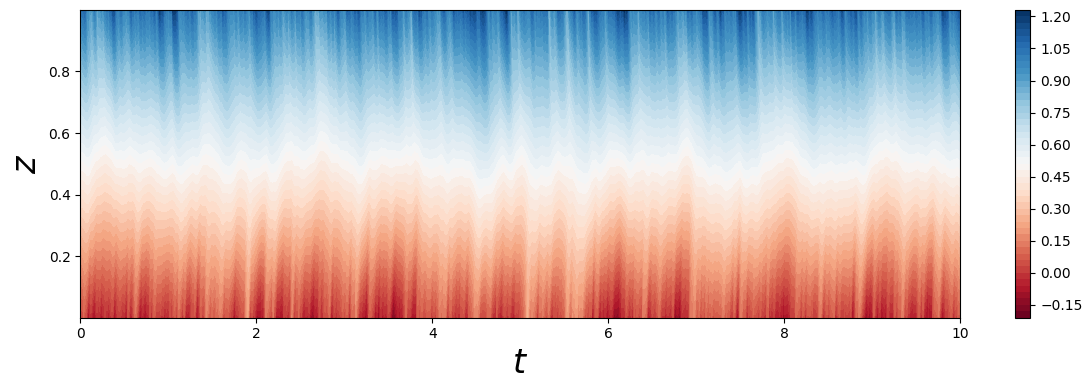

In [12]:
Solve(N=1000,T=10,Nz=32,κ=1, a=1,σ=0.05,τ=.1)

import matplotlib.pyplot as plt
#plt.rcParams['mathtext.fontset'] = 'cm'
#plt.rcParams['font.family'] = 'STIXGeneral'

# Data loading
file   = h5py.File('Y_snapshots/Y_snapshots_s1.h5', mode='r')

# Data (t,z)
Y_vec  = file['tasks/Y' ][:,:]
z_vec  = file['tasks/Y'].dims[1][0][:]
t_vec  = file['tasks/Y'].dims[0][0][:]

fig = plt.figure(figsize=(12,4))
plt.contourf(t_vec,z_vec,Y_vec.T,levels=50,cmap='RdBu')
plt.colorbar()
plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$z$',fontsize=24)
plt.tight_layout()
plt.show()

The forward Kolmogorov equation describing the *global scalar concentration* is given by
\begin{equation}
\frac{\partial }{ \partial t} f = -\frac{\partial}{ \partial y} \left( \mathbb{D}^{(1)} f \right) + \frac{\partial^2 }{ \partial y^2} \left( \mathbb{D}^{(2)} f \right),
\end{equation}
where
\begin{equation}
\mathbb{D}^{(1)} = \mathbb{E}_{Y_t}[\kappa \left( \boldsymbol{n} \cdot \nabla Y_t \right) ] \frac{h}{f}, \quad\quad \mathbb{D}^{(2)} = \mathbb{E}_{Y_t}[-\kappa|\nabla Y|^2],
\end{equation}
and $h(y;t)$ corresponds to the (unnormalised) density when $Y_t$ is sampled from the boundary of the domain and $f(y;t)$ is the global probability density function. This density describes the probability of finding a scalar concentration $y$ at a time $t$ in the interval $z \in [0,1]$. Having time integrated the transport equation for the solute concentration we have a set of snapshots $Y_t(z)$ at discrete time intervals $t_n$. Loading the numerical snapshots saved below we now use this data to calculate the terms in this equation.

In [5]:
def Data():

  # Data loading
  file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

  # Interpolate the data (t,z) from a Chebyshev grid onto a uniform grid
  Y_cheb  = file['tasks/Y' ][:,:]
  Yz_cheb = file['tasks/Yz'][:,:]
  z_cheb  = file['tasks/Y'].dims[1][0][:]
  times   = file['tasks/Y'].dims[0][0][:]

  dz_cheb = z_cheb[1]-z_cheb[0];
  z_data  = np.arange(0,1,dz_cheb);
  s       = (len(times),len(z_data));
  Y_data  = np.zeros(s)
  Yz_data = np.zeros(s)
  for i,t in enumerate(times):
    Y_data[i,:] = np.interp(z_data, z_cheb, Y_cheb[i,:] )
    Yz_data[i,:]= np.interp(z_data, z_cheb, Yz_cheb[i,:])
  dY2_data = Yz_data**2;

  return times, z_data,Y_data,Yz_data,dY2_data;

*Time derivative*

To evaluate the left hand side we estimate the pdf $f$ (using a histogram) and then compute its time derivative $\partial_t f$ using central differences.

In [8]:
def df_dt(times,Y_data,Range,N_bins):

  # PDF f_C
  f_np1,y = np.histogram(Y_data[-2,...].flatten(),range=Range,bins=N_bins,density=True); # n + 1 (-2)
  f    ,y = np.histogram(Y_data[-3,...].flatten(),range=Range,bins=N_bins,density=True); # n + 1 (-2)
  f_nm1,y = np.histogram(Y_data[-4,...].flatten(),range=Range,bins=N_bins,density=True); # n - 1 (-4)
  y       = 0.5*(y[1:] + y[:-1]);

  # Time derivate df/dt
  dt   =  times[-1] - times[-2];
  dfdt = (f_np1 - f_nm1)/2.
  dfdt /=dt;

  return dfdt,f,y

*Diffusion Coefficient*

For the right hand side we first compute the diffusion coefficient
\begin{equation}
\mathbb{D}^{(2)} \equiv \mathbb{E}_{Y_t}[- \kappa|\nabla Y_t|^2] = - \kappa\int \phi \frac{ f(\phi,y,t) }{f(y,t)} d \phi, \quad \text{where} \quad \phi = |\nabla Y_t|^2,
\end{equation}
by using the fact that the conditional expectation can be re-expressed in terms of its joint density. This coefficent is calculated below by estimating the joint density using a histogram. Subsequently we create the derivative operator $L = \partial^2_y$ using central differences. Having used central differencing to estimate the time derivative centered at time index n=-3 we must evaluate this conditional expectation at the same index.

In [9]:
def diffusion(dY2_data,Y_data,κ,Range,N_bins):

  # Expectation
  # Let Φ = |∇Y|^2 and φ its dummy variable
  f_YΦ,y,φ = np.histogram2d(Y_data[-3,...].flatten(), dY2_data[-3,...].flatten(),range = (Range,(min(dY2_data[-3,:]),max(dY2_data[-3,:]))),bins=N_bins,density=True) # n (-3)
  φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
  y = .5*(y[1:]+y[:-1]); dy = y[1] - y[0];
  f_Y =  np.sum(  f_YΦ,axis=1)*dφ;      # f_Y(y)
  E   = (np.sum(φ*f_YΦ,axis=1)*dφ)/f_Y; # E{Φ|Y} = int_φ f_Φ|Y(φ|y)*φ dφ
  D1  = -κ*E

  return D1,E

def Laplacian(y):

  N = len(y)
  dy= y[1]-y[0]
  L = np.zeros((N,N))
  for i in range(N):

    if i == 0:
        L[i,i  ] = -2.
        L[i,i+1] =  1
    elif i == N-1:
        L[i,i-1] =  1.
        L[i,i  ] = -2
    else:
        L[i,i-1] =  1
        L[i,i  ] = -2.
        L[i,i+1] =  1

  L   *= 1./(dy**2);
  return L;

*Drift coefficient*

The drift coefficient for this one dimensional case reduces to
\begin{equation}
\mathbb{D}^{(1)} = \frac{\kappa}{f} \Bigl( \mathbb{E}_{Y_t}[ \nabla_z Y_t(z=1)] h(y|z=1,t) - \mathbb{E}_{Y_t}[\nabla_z Y_t(z=0) ]h(y|z=0,t) \Bigr)
\end{equation}
where the (unnormalised) density $h$ is given by the solution to the Ornstein-Ulhenbeck process on each boundary
\begin{equation}
h(y|z=1,t) = , \quad h(y|z=0,t) =,
\end{equation}
while the gradient of $Y_t$ on the boundary must be determined numerically. Given that the product of the density and the conditional average of the gradient of $Y_t$ on the boundary can be caculated as
\begin{equation}
\mathbb{E}_{Y_t}[ \nabla_z Y_t(z=1)] h(y|z=1,t) = \int \phi h(\phi, y |z=1,t) d\phi, \quad \text{where} \quad \phi = \nabla y,
\end{equation}
shows that this problem reduces to knowledge of $h(\nabla y, y|z,t)$ on the boundaries.

In [ ]:
def drift(f,y,times,σ,κ):

  file  = h5py.File('snapshots/snapshots_s1.h5', mode='r')
  dY_z0 = file['tasks/Yz'][-3, 0]
  dY_z1 = file['tasks/Yz'][-3,-1]

  h_z0  = ss.norm.pdf(y,loc=0,scale=σ)
  h_z1  = ss.norm.pdf(y,loc=1,scale=σ)
  D1    =  (κ/f)*( dY_z1*h_z1 - dY_z0*h_z0 )

  int_h_z0  = ss.norm.cdf(y,loc=0,scale=σ)
  int_h_z1  = ss.norm.cdf(y,loc=1,scale=σ)
  int_D1f   = κ*(dY_z1*int_h_z1 - dY_z0*int_h_z0)

  return D1,int_D1f

**Results**

Having computed the terms appearing in the left and right hand sides of the forward Kolmogorov for this advection diffusion problem we now investigate their form as well as validating that the left and right hand sides are equal. The figure below plots (a) the scalar field $Y_{t}(z)$, (b) the density and the dirft and diffusion coefficients $f, \mathbb{D}^{(1)}, \mathbb{D}^{(2)}$ and (c) the right and left hand sides of the forward Kolmogorov equation.


To avoid artificially smoothing the data in frame (c) we twice integrate the forward Kolmogorov equation with respect to $y$ when comparing the left and right hand side. In particular we treat the drift term analytically using the fact that the fact that
\begin{equation}
\int \mathbb{E}[\phi|Y_t = c]h(y) dy  = \int \mathbb{E}[\phi|Y_t = c] \mathcal{N}(\mu_z,\sigma^2) dy =  \mathbb{E}[\phi|Y_t =c] \int \mathcal{N}(\mu_z,\sigma^2) dy,
\end{equation}
where $c$ is a constant.

In [ ]:
import matplotlib.pyplot as plt
#%matplotlib widget
#plt.rcParams['mathtext.fontset'] = 'cm'
#plt.rcParams['font.family'] = 'STIXGeneral'

def Plot_Terms(z_data,Y_data,y,f,D1,D2,LHS,RHS):

  fig      = plt.figure(layout='constrained',figsize=(12,6))
  subplots = fig.subfigures(1,3, wspace=0.05)

  ax0 = subplots[0].subplots(1,1)
  ax1 = subplots[1].subplots(3,1,sharex=True)
  ax2 = subplots[2].subplots(1,1)

  # ~~~~~~~~~ (a) ~~~~~~~
  ax0.plot(z_data,Y_data[-3,:],'k')
  ax0.set_xlim([0,1])
  ax0.set_xlabel(r'$z$',fontsize=20)
  ax0.set_ylabel(r'$Y_t(z)$',fontsize=20)

  # ~~~~~~~~~ (b) ~~~~~~~
  ax1[0].plot(y,f,'r', linewidth=2,label=r'$f(y,t_n)$')
  ax1[0].fill_between(x=y,y1=f,color= "r",alpha= 0.2)
  ax1[1].plot(y,D1,'b', linewidth=2,label=r'$D^{(1)}$')
  ax1[2].plot(y,D2,'b', linewidth=2,label=r'$D^{(2)}$')

  for ax in ax1:
    ax.legend(loc=8,fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

  ax1[2].set_xlabel(r'$y$',fontsize=24)

  # ~~~~~~~~~ (c) ~~~~~~~
  ax2.plot(y,LHS,'r-',label=r'$\int \int ( \partial_t f) dydy$')
  ax2.plot(y,RHS,'b-',label=r'$-\int ( \mathbb{D}^{(1)} f ) dy + D^{(2)} f $')
  ax2.set_xlabel(r'$c$',fontsize=24)
  ax2.legend(loc=8,fontsize=16)

  for n,ax in enumerate([ax0,ax2]):
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

  plt.savefig('1D_Diffusion.png',dpi=200)
  plt.show()

  return None;

*Dirichelt Validation $\beta=0$*

2024-04-25 17:24:47,817 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2024-04-25 17:24:47,819 __main__ 0/1 INFO :: Starting main loop
2024-04-25 17:24:48,206 solvers 0/1 INFO :: Simulation stop time reached.
2024-04-25 17:24:48,446 matplotlib.mathtext 0/1 INFO :: Substituting symbol D from STIXGeneral
2024-04-25 17:24:48,954 matplotlib.mathtext 0/1 INFO :: Substituting symbol D from STIXGeneral
2024-04-25 17:24:49,727 matplotlib.mathtext 0/1 INFO :: Substituting symbol D from STIXGeneral


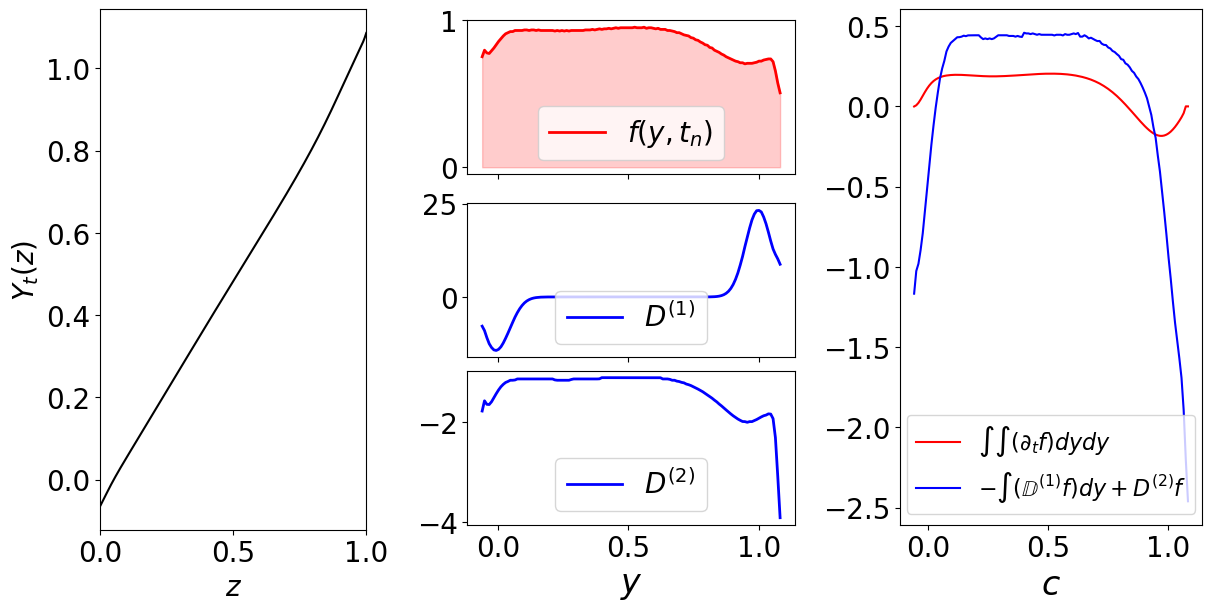

In [ ]:
κ=1
τ=.1
σ=0.05
a=1

# Solve & grab the data
Solve(N=100,T=.1,Nz=256,κ=κ,σ=σ,a=a,τ=τ)
times, z_data,Y_data,Yz_data,dY2_data = Data()

Range = (min(Y_data[-3,:]),max(Y_data[-3,:]));
#Range = (0,1)
N_bins=128

# Estimate the terms
dfdt,f,y  = df_dt(times,Y_data,         Range=Range,N_bins=N_bins)
D2,E      = diffusion(dY2_data,Y_data,κ,Range=Range,N_bins=N_bins)
D1,int_D1f= drift(f,y,times,σ,κ)

L   = Laplacian(y);
LHS = np.linalg.solve(L,dfdt)
RHS = D2*f -int_D1f

Plot_Terms(z_data,Y_data,y,f,D1,D2,LHS,RHS)